In [6]:
import pandas as pd
import glob

# Load all relevant files in the correct order (-1, 0, 1)
files = sorted(glob.glob("data/prices_round_2_day_*.csv"), key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Filter for specific products
target_products = {"CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"}

# Collect filtered dataframes
filtered_dfs = []

for file in files:
    day = int(file.split("_")[-1].split(".")[0])
    df = pd.read_csv(file, sep=";")
    filtered_df = df[df["product"].isin(target_products)].copy()

    timestamp_offsets = {-1: 0, 0: 1_000_000, 1: 2_000_000}
    filtered_df["timestamp"] += timestamp_offsets[day]
    filtered_dfs.append(filtered_df)

# Combine all filtered dataframes
combined_df = pd.concat(filtered_dfs, ignore_index=True)

# Save to a new CSV
output_path = "./data/combined_picnic_data.csv"
combined_df.to_csv(output_path, index=False)

print(f"Combined CSV saved to {output_path}")


Combined CSV saved to ./data/combined_picnic_data.csv


In [2]:
import pandas as pd

# Load the combined data
df = pd.read_csv("./data/combined_picnic_data.csv")  # comma separator is default, so no need to specify

# Pivot so we get one row per timestamp with each product as a column
pivoted = df.pivot(index="timestamp", columns="product", values="mid_price")

# Optionally drop rows where any required price is missing
pivoted = pivoted.dropna(subset=["CROISSANTS", "JAMS", "DJEMBES", "PICNIC_BASKET1", "PICNIC_BASKET2"])

# Compute fair values
pivoted["FAIR_BASKET1"] = 6 * pivoted["CROISSANTS"] + 3 * pivoted["JAMS"] + pivoted["DJEMBES"]
pivoted["FAIR_BASKET2"] = 4 * pivoted["CROISSANTS"] + 2 * pivoted["JAMS"]

# Compute differences between actual and fair values
pivoted["DIFF_BASKET1"] = pivoted["PICNIC_BASKET1"] - pivoted["FAIR_BASKET1"]
pivoted["DIFF_BASKET2"] = pivoted["PICNIC_BASKET2"] - pivoted["FAIR_BASKET2"]

pivoted.head()


product,CROISSANTS,DJEMBES,JAMS,PICNIC_BASKET1,PICNIC_BASKET2,FAIR_BASKET1,FAIR_BASKET2,DIFF_BASKET1,DIFF_BASKET2
timestamp,,,,,,,,,
0,4304.5,13450.5,6670.5,59289.0,30609.0,59289.0,30559.0,0.0,50.0
100,4304.5,13450.0,6670.5,59287.0,30613.0,59288.5,30559.0,-1.5,54.0
200,4304.5,13450.5,6671.0,59293.5,30615.0,59290.5,30560.0,3.0,55.0
300,4304.5,13450.0,6672.0,59293.5,30620.5,59293.0,30562.0,0.5,58.5
400,4305.5,13452.5,6672.0,59292.0,30621.0,59301.5,30566.0,-9.5,55.0


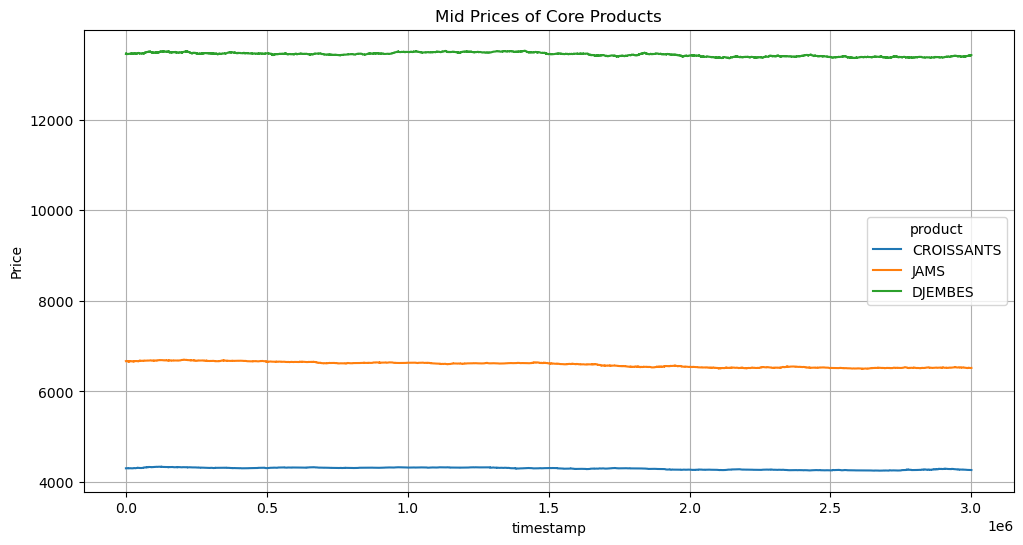

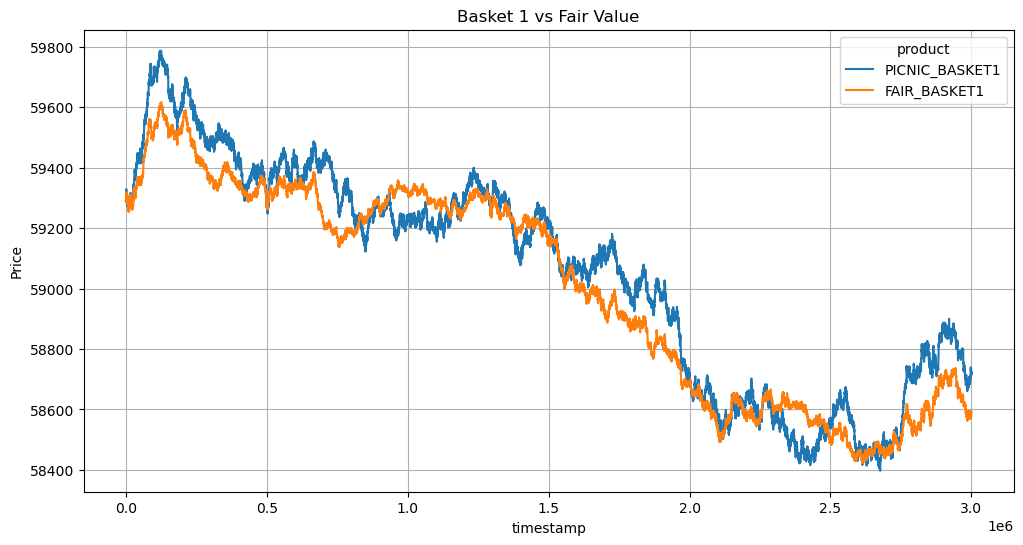

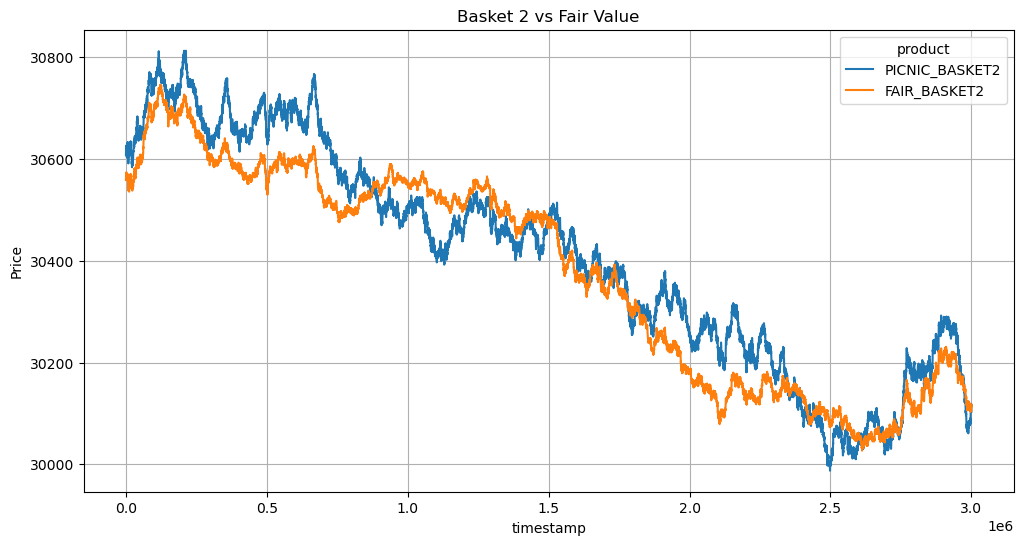

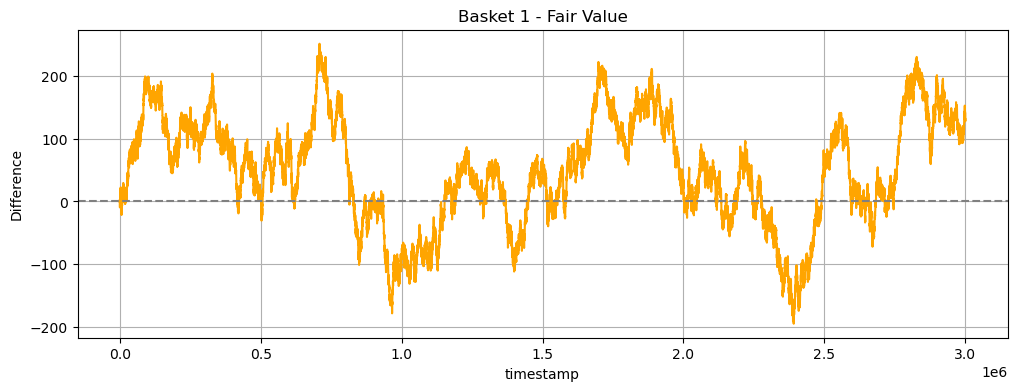

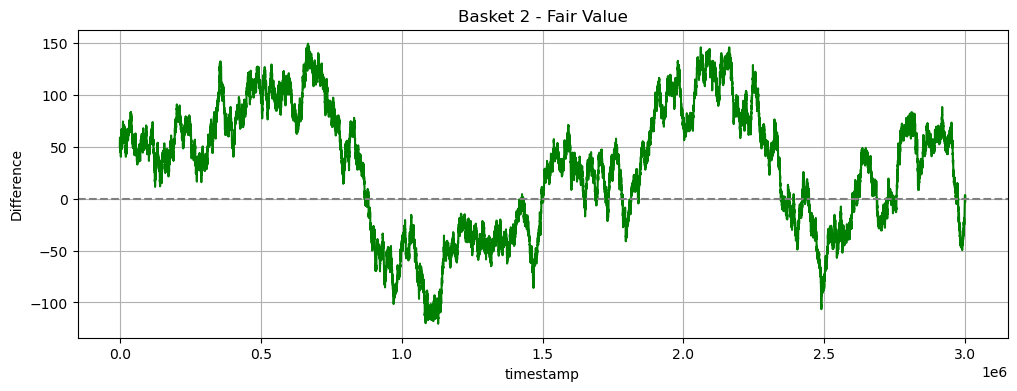

In [8]:
import matplotlib.pyplot as plt

# Plot individual products
pivoted[["CROISSANTS", "JAMS", "DJEMBES"]].plot(figsize=(12, 6), title="Mid Prices of Core Products")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Plot Basket 1 vs its Fair Value
pivoted[["PICNIC_BASKET1", "FAIR_BASKET1"]].plot(figsize=(12, 6), title="Basket 1 vs Fair Value")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Plot Basket 2 vs its Fair Value
pivoted[["PICNIC_BASKET2", "FAIR_BASKET2"]].plot(figsize=(12, 6), title="Basket 2 vs Fair Value")
plt.ylabel("Price")
plt.grid(True)
plt.show()

# Plot diff for Basket 1
pivoted["DIFF_BASKET1"].plot(figsize=(12, 4), title="Basket 1 - Fair Value", color="orange")
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Difference")
plt.grid(True)
plt.show()

# Plot diff for Basket 2
pivoted["DIFF_BASKET2"].plot(figsize=(12, 4), title="Basket 2 - Fair Value", color="green")
plt.axhline(0, linestyle="--", color="gray")
plt.ylabel("Difference")
plt.grid(True)
plt.show()


In [9]:
import numpy as np
import pandas as pd

results = []

for lower in range(-150, -30, 10):
    for upper in range(50, 200, 10):
        position = 0
        cash = 0

        for _, row in pivoted.iterrows():
            price = row["PICNIC_BASKET1"]
            diff = row["DIFF_BASKET1"]

            # Buy when undervalued
            if diff < lower and position < 1:
                position += 1
                cash -= price
            # Sell when overvalued
            elif diff > upper and position > -1:
                position -= 1
                cash += price

        unrealized = position * pivoted["PICNIC_BASKET1"].iloc[-1]
        final_pnl = cash + unrealized
        results.append((lower, upper, final_pnl))

# Find best
results_df = pd.DataFrame(results, columns=["lower", "upper", "pnl"])
best = results_df.sort_values("pnl", ascending=False).iloc[0]
best


lower     -40.0
upper      70.0
pnl      1710.5
Name: 167, dtype: float64

In [10]:
import numpy as np
import pandas as pd

results = []

for lower in range(-150, -30, 10):
    for upper in range(50, 200, 10):
        position = 0
        cash = 0

        for _, row in pivoted.iterrows():
            price = row["PICNIC_BASKET2"]
            diff = row["DIFF_BASKET2"]

            # Buy when undervalued
            if diff < lower and position < 1:
                position += 1
                cash -= price
            # Sell when overvalued
            elif diff > upper and position > -1:
                position -= 1
                cash += price

        unrealized = position * pivoted["PICNIC_BASKET2"].iloc[-1]
        final_pnl = cash + unrealized
        results.append((lower, upper, final_pnl))

# Find best
results_df = pd.DataFrame(results, columns=["lower", "upper", "pnl"])
best = results_df.sort_values("pnl", ascending=False).iloc[0]
best


lower   -100.0
upper     60.0
pnl      970.0
Name: 76, dtype: float64

In [3]:
import pandas as pd


mean_diff_basket1 = pivoted["DIFF_BASKET1"].mean()
mean_diff_basket2 = pivoted["DIFF_BASKET2"].mean()

mean_diff_basket1, mean_diff_basket2

(48.762433333333334, 30.235966666666666)

In [4]:
import numpy as np
import pandas as pd

# Precompute stats
mean = pivoted["DIFF_BASKET2"].mean()
std = pivoted["DIFF_BASKET2"].std()

# Parameters
max_trade = 1
z_range = np.linspace(0.5, 2.5, 21)
results = []

for buy_thresh in z_range:
    for sell_thresh in z_range:
        position = 0
        cash = 0

        for _, row in pivoted.iterrows():
            price = row["PICNIC_BASKET2"]
            diff = row["DIFF_BASKET2"]

            z = (diff - mean) / std if std != 0 else 0
            qty = max_trade  # could scale with abs(z)

            # Buy signal (undervalued)
            if z < -buy_thresh and position < 1:
                position += qty
                cash -= price * qty

            # Sell signal (overvalued)
            elif z > sell_thresh and position > -1:
                position -= qty
                cash += price * qty

        final_price = pivoted["PICNIC_BASKET2"].iloc[-1]
        unrealized = position * final_price
        pnl = cash + unrealized
        results.append((buy_thresh, sell_thresh, pnl))

# Results dataframe
results_df = pd.DataFrame(results, columns=["buy_z", "sell_z", "pnl"])
best = results_df.sort_values("pnl", ascending=False).iloc[0]
best


buy_z        2.2
sell_z       0.9
pnl       1051.0
Name: 361, dtype: float64

In [6]:
results_df.to_csv("zscore_threshold_results_basket2.csv", index=False)


In [ ]:
results_df = pd.read_csv("zscore_threshold_results_basket2.csv")
heatmap_data = results_df.pivot(index="buy_z", columns="sell_z", values="pnl")

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.title("PnL Heatmap for Z-Score Thresholds (Basket 2)")
plt.xlabel("Sell Z-Threshold")
plt.ylabel("Buy Z-Threshold")
sns = __import__("seaborn")
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="RdYlGn", center=0)
plt.tight_layout()
plt.show()


KeyError: 'DIFF_BASKET2'